In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# 1. Data Preprocessing

In [ ]:
base_dir = Path('./Original Reddit Data/raw data')  # Current dir
monthly_df = []
years = ['2019', '2020', '2021', '2022']

for year in years:
    year_dir = base_dir / year
        
    print(f"Processing year: {year}")
    # month folder in year
    for subdir_path in year_dir.iterdir():
        if not subdir_path.is_dir():
            continue
            
        print(f"  Processing subdirectory: {subdir_path.name}")
        # Find all CSV files in the subdir
        csv_files = list(subdir_path.glob('*.csv'))
        
        for csv_file in csv_files:
            print(f"    Reading file: {csv_file.name}")
            df = pd.read_csv(csv_file)
            df = df.drop(df.columns[0], axis=1) # drop first col
            monthly_df.append(df)

# Concat all dataframes
if monthly_df:
    df = pd.concat(monthly_df, ignore_index=True)
else:
    print("No CSV files found or all files were empty.")

df.to_csv('data/RMHD_raw.csv', index=False)

In [3]:
df = pd.read_csv('data/RMHD_raw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851580 entries, 0 to 1851579
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   author       object
 1   created_utc  int64 
 2   score        int64 
 3   selftext     object
 4   subreddit    object
 5   title        object
 6   timestamp    object
dtypes: int64(2), object(5)
memory usage: 98.9+ MB


In [4]:
# find nan in each column
print(df.isnull().sum())
# drop rows with nan
df.dropna(inplace=True)

author             0
created_utc        0
score              0
selftext       54564
subreddit          0
title              8
timestamp          0
dtype: int64


In [5]:
# convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.drop(columns=['created_utc'], inplace=True)

subreddit
depression                                                                                                            620317
SuicideWatch                                                                                                          452458
mentalhealth                                                                                                          298409
Anxiety                                                                                                               268539
lonely                                                                                                                153575
If anyone is afraid to call a suicide hotline please message me and I will gladly arrange a phone call with you ❤️         9
.                                                                                                                          9
My bestfriend and I made a suicide pact.                                                                           

Text(0.5, 1.0, 'Subreddit distribution')

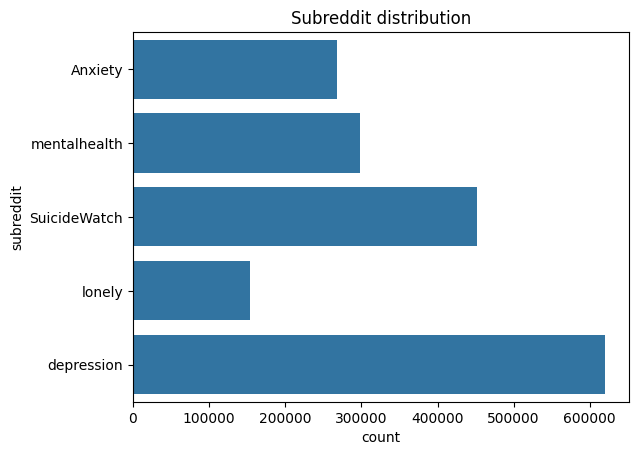

In [6]:
print(df['subreddit'].value_counts().head(10))
# keep only top 5
top5 = df['subreddit'].value_counts().head(5).index
df = df[df['subreddit'].isin(top5)]

sns.countplot(y='subreddit', data=df)
plt.title('Subreddit distribution')

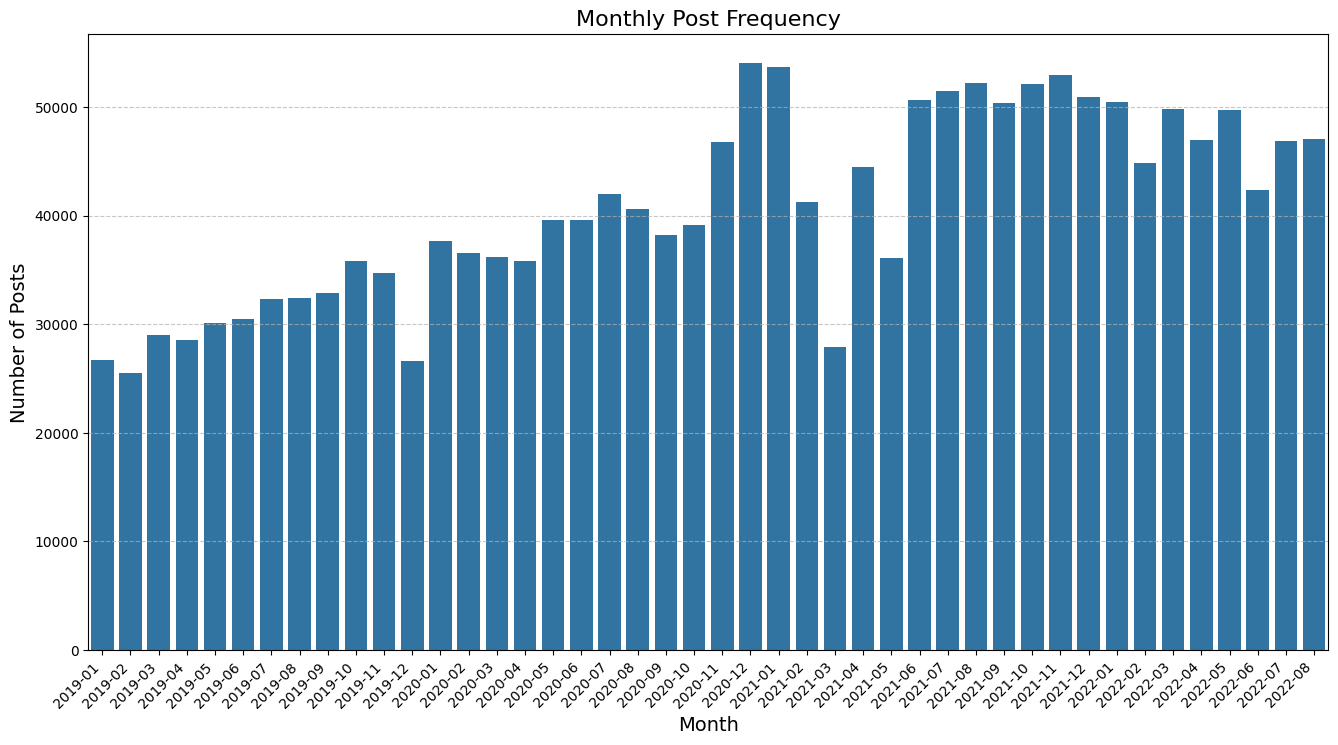

In [7]:
plt.figure(figsize=(16, 8))

sns.barplot(df['timestamp'].dt.to_period('M').value_counts().sort_index())

# Customize appearance
plt.title('Monthly Post Frequency', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Text Preprocessing 

In [21]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
import string
import emoji

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [11]:
reddit_stop_words = {
    'reddit', 'upvote', 'downvote', 'karma', 'subreddit', 'edit', 'tldr', 
    'op', 'deleted', 'removed', 'permalink', 'gilded', 'awarded', 'mod', 
    'throwaway', 'redditor', 'updoot', 'flair', 'repost', 'crosspost'
}
stop_words.update(reddit_stop_words)

In [12]:
mental_health_terms = {
    'anxiety', 'depression', 'therapy', 'therapist', 'medication', 'meds',
    'diagnosis', 'disorder', 'mental', 'health', 'stress', 'panic',
    'attack', 'fear', 'worry', 'trauma', 'ptsd', 'ocd', 'adhd', 'bipolar'
}
stop_words = stop_words - mental_health_terms

In [13]:
def clean_reddit_data(df):

    cleaned_df = df.copy()
    removed_patterns = [
        '[removed]', '[deleted]', '[removed by reddit]', 
        'deleted', 'removed', '\[removed\]', '\[deleted\]'
    ]
    
    for col in ['selftext', 'title']:
        if col in cleaned_df.columns:
            for pattern in removed_patterns:
                cleaned_df[col] = cleaned_df[col].replace(pattern, np.nan)

            cleaned_df[col] = cleaned_df[col].replace('', np.nan)
    
    if 'title' in cleaned_df.columns and 'selftext' in cleaned_df.columns:
        cleaned_df['has_content'] = (~cleaned_df['title'].isna()) | (~cleaned_df['selftext'].isna())
        cleaned_df = cleaned_df[cleaned_df['has_content']].drop('has_content', axis=1)

    if 'created_utc' in cleaned_df.columns and 'timestamp' not in cleaned_df.columns:
        cleaned_df['timestamp'] = pd.to_datetime(cleaned_df['created_utc'], unit='s')
    
    return cleaned_df

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_579/3088254418.py:6: SyntaxWarning: invalid escape sequence '\['
  'deleted', 'removed', '\[removed\]', '\[deleted\]'
/tmp/ipykernel_579/3088254418.py:6: SyntaxWarning: invalid escape sequence '\['
  'deleted', 'removed', '\[removed\]', '\[deleted\]'


In [14]:
def preprocess_text(text, stem=False, keep_emojis=True, min_word_length=2):

    if not isinstance(text, str) or pd.isna(text):
        return ""

    emojis_map = {}
    if keep_emojis:
        for char in text:
            if char in emoji.EMOJI_DATA:
                emoji_name = emoji.demojize(char).replace(':', '').replace('_', ' ')
                text_description = f"{emoji_name}_emoji"
                emojis_map[char] = text_description
        
        for emoji_char, description in emojis_map.items():
            text = text.replace(emoji_char, f" {description} ")
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove Reddit user references (u/username)
    text = re.sub(r'u/\w+', '', text)
    
    # Remove Reddit subreddit references (r/subreddit)
    text = re.sub(r'r/\w+', '', text)
    
    # Remove Reddit formatting tags [text], (text)
    text = re.sub(r'\[.*?\]|\(.*?\)', '', text)
    
    # Remove specific Reddit terms like EDIT:, TL;DR:
    text = re.sub(r'\bEDIT\s*:|edit\s*:|tldr\s*:|tl;dr\s*:', '', text)
    
    # Remove HTML entities (&amp; etc.)
    text = re.sub(r'&[a-z]+;', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text into words
    tokens = word_tokenize(text)
    
    # Process tokens based on stemming or lemmatization choice
    if stem:
        # Apply stemming
        cleaned_tokens = [stemmer.stem(word) for word in tokens 
                         if word not in stop_words and len(word) >= min_word_length]
    else:
        # Apply lemmatization
        cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens 
                         if word not in stop_words and len(word) >= min_word_length]
    
    # Rejoin into a single string
    return ' '.join(cleaned_tokens)

In [15]:
cleaned_df = clean_reddit_data(df)

In [16]:
for col in ['title', 'selftext']:
    if col in cleaned_df.columns:
        cleaned_df[f'{col}_processed'] = cleaned_df[col].apply(
            lambda x: preprocess_text(x, stem=False)
        )

In [17]:
cleaned_df.head()

,author,score,selftext,subreddit,title,timestamp,title_processed,selftext_processed
0,lavender__unicorn,4,I just started a new job (this will be my seco...,Anxiety,New job + teeth grinding,2019-09-30 23:40:28,new job teeth grinding,started new job town went college far love job...
1,IllustriousCareer6,1,I got a job in a construction market where I h...,Anxiety,"My first day at work begins in a couple hours,...",2019-09-30 23:15:03,first day work begin couple hour feeling reall...,got job construction market help customer find...
2,Justcallme__rae,2,I’m having a hard time now because I just brok...,Anxiety,"If someone sees you in a bad way, how do you l...",2019-09-30 22:52:13,someone see bad way let go,hard time broke ex seeing thing way wanted u s...
3,PurpleSpannerPony,1,My boyfriend is going away this weekend and as...,Anxiety,He’s going away this weekend,2019-09-30 22:45:13,going away weekend,boyfriend going away weekend date draw nearer ...
4,loathe-entirely,8,I work for a small company and the one person ...,Anxiety,Manager’s response to my anxiety is making eve...,2019-09-30 22:41:55,manager response anxiety making everything worse,work small company one person responsible part...


In [18]:
print("Original Title:")
print(cleaned_df['title'].iloc[0])
print("\nProcessed Title:")
print(cleaned_df['title_processed'].iloc[0])

print("Original Selftext:")
print(cleaned_df['selftext'].iloc[0])
print("\nProcessed Selftext:")
print(cleaned_df['selftext_processed'].iloc[0])

Original Title:
New job + teeth grinding

Processed Title:
new job teeth grinding
Original Selftext:
I just started a new job (this will be my second week) in the town that I went to college in. So far, I love my job and the students that I work with. I'm currently staying with a family friend who is lovely and I get a long with well. So in general I'm not currently stressed or feeling unhappy. 

BUT for some reason, since last week I have started grinding my teeth at night and clenching my jaw during the day. I have never had this problem before, and other than a night guard I don't really know what else to try (I can't wear one during the day). 

I've also noticed that, although I'm a jumpy person in general, my jumpiness has increased tenfold the last couple of days. Sounds are louder and stick out more. Last night I slept terribly. 

I have tried bedtime yoga, journaling, tea, and meditating. I feel like this is my anxiety manifesting in a new way. Does anyone have any tips or has 

In [19]:
cleaned_df.to_csv('data/RMHD_TextProcessed.csv', index=False)